In [1]:
import os
# Configure which GPU 
gpu_num = 1 # Use "" to use the CPU
os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Import Sionna
import sionna
sionna.config.xla_compat=True #需要进一步改动代码，以加快执行速度

# Configure the notebook to use only a single GPU and allocate only as much memory as needed
# For more details, see https://www.tensorflow.org/guide/gpu
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')


# Set global random seed for reproducibility
            
import numpy as np
import sionna.rt as rt
from sionna.constants import PI
from sionna.channel import cir_to_ofdm_channel
import matplotlib.pyplot as plt
import utils

if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e) 

tf.random.set_seed(1)

In [2]:
# set scatterers
scatter_infos = []

# scatterer 0
mat_type_table = np.ones([10, 10])
for ii in range(3):
    for jj in range(ii+1):
        mat_type_table[(ii*3+1):(ii*3+3), ((jj)*3+1):(jj*3+3)] = 0
mat_type_table = tf.convert_to_tensor(mat_type_table, dtype=tf.int32)
roughness = tf.convert_to_tensor([10, 1e-3])
em_prop = tf.convert_to_tensor([tf.complex(6.31, -0.26), tf.complex(5.24, -0.34)])
roughness_table, em_prop_table = utils.Scatter_info.gen_table(mat_type_table, roughness, em_prop)
tile_length = 3.06
tile_width = 3.06
transform = tf.convert_to_tensor([[0., 0., 0.], [0., 0., 0.]])
scatter_infos.append(utils.Scatter_info(roughness_table, em_prop_table, tile_length, tile_width, transform))

#scatterer 1
mat_type_table = np.ones([5, 5])
for ii in range(5):
    for jj in range(ii+1):
        mat_type_table[ii,jj] = 0
mat_type_table = tf.convert_to_tensor(mat_type_table, dtype=tf.int32)
roughness = tf.convert_to_tensor([10, 1e-3])
em_prop = tf.convert_to_tensor([tf.complex(6.31, -0.26), tf.complex(5.24, -0.34)])
roughness_table, em_prop_table = utils.Scatter_info.gen_table(mat_type_table, roughness, em_prop)
tile_length = 3
tile_width = 3
transform = tf.convert_to_tensor([[7., 18., 9.], [0., 0., -PI/2]])
scatter_infos.append(utils.Scatter_info(roughness_table, em_prop_table, tile_length, tile_width, transform))

#scatterer 2
mat_type_table = np.ones([5, 5])
for ii in range(5):
    for jj in range(ii+1):
        mat_type_table[ii,jj] = 0
mat_type_table = tf.convert_to_tensor(mat_type_table, dtype=tf.int32)
roughness = tf.convert_to_tensor([10, 1e-3])
em_prop = tf.convert_to_tensor([tf.complex(6.31, -0.26), tf.complex(5.24, -0.34)])
roughness_table, em_prop_table = utils.Scatter_info.gen_table(mat_type_table, roughness, em_prop)
tile_length = 3
tile_width = 3
transform = tf.convert_to_tensor([[-7., -18., 9.], [0., 0., PI/2]])
scatter_infos.append(utils.Scatter_info(roughness_table, em_prop_table, tile_length, tile_width, transform))

# sequence: elm_2, elm_6, elm_8
scatter_labels = ['elm__2','elm__6','elm__8']
scatter_ids = []

scene = rt.load_scene("/home/zhl/trial_project/scene/multiple_scatters/multiple_scatters.xml")
for ii in range(len(scatter_labels)):
    scatter_ids.append(scene.objects[scatter_labels[ii]].object_id)

id_hash = np.ones(max(scatter_ids) + 1) * -1
for ii in range(len(scatter_labels)):
    id_hash[scene.objects[scatter_labels[ii]].object_id] = ii
id_hash = tf.convert_to_tensor(id_hash, dtype=tf.int32)

em_property = utils.Em_property(scatter_infos, id_hash)

scene.frequency = 3e9
scene.radio_material_callable = utils.Combined_radio_material(em_property=em_property)
scene.scattering_pattern_callable = utils.Combined_scatter(em_property=em_property)
tx_antenna_num = 4
rx_antenna_num = 4

scene.tx_array = rt.PlanarArray(num_rows=tx_antenna_num, num_cols=1, 
                                vertical_spacing=0.5, 
                                horizontal_spacing=0.5, 
                                pattern="hw_dipole", 
                                polarization="V")
scene.rx_array = rt.PlanarArray(num_rows=rx_antenna_num, num_cols=1, 
                                vertical_spacing=0.5, 
                                horizontal_spacing=0.5, 
                                pattern="hw_dipole", 
                                polarization="V")

scene.add(rt.Transmitter(name="Tx", 
                         position=[-50, 0, 50], 
                         orientation=[0, PI/4, 0]))



In [3]:
BW = 150e6
num_freq = 11
frequencies = np.linspace(scene.frequency - 0.5 * BW, scene.frequency + 0.5 * BW, num_freq)
frequencies = tf.convert_to_tensor(frequencies)
frequencies = tf.cast(frequencies, tf.float32)
noise = 1e-9
SNR = 1 / noise

train_size = 2000
cube_length = 3
random_phase = True
#使用一对收发天线的频响训练，在此指定天线编号
tx_for_train = 0
rx_for_train = 0
#如果外推空间相关矩阵，在此指定子载波序号
sc_for_train = 0

In [4]:
theta = 2 * PI / 3 * np.random.rand() + PI * 6
height_shift = 6 * np.random.rand() - 3
""" train_position = [12 * np.sin(theta) - cube_length / 2,
                  12 * np.cos(theta) - cube_length / 2, 
                  4 + height_shift - cube_length / 2]  """
train_position = [9.38, 7.32, 2.40]
# train_position = cube_length * np.random.rand(3) + train_position
print(train_position)

for keys in scene.receivers:
    scene.remove(keys)
for jj in range(train_size):
    Rx_pos = cube_length * np.random.rand(3) + np.array(train_position)
    scene.add(rt.Receiver(name=f"Rx_{jj}", position=Rx_pos, orientation=[0, -PI/4, 0]))
paths = scene.compute_paths(check_scene=False, 
                                    num_samples=1e5,
                                    los=False,
                                    reflection=False, 
                                    scattering=True, 
                                    scat_random_phases=random_phase, 
                                    scat_keep_prob=1)

h_f = cir_to_ofdm_channel(frequencies, paths.a, paths.tau)
h_f = tf.squeeze(tf.squeeze(h_f)[:,rx_for_train,tx_for_train,:])

R_hf = tf.matmul(tf.transpose(h_f, conjugate=True), h_f) / train_size

[9.38, 7.32, 2.4]


In [5]:
# 产生测试集ground truth,不限于频域的相关矩阵，需与最后一块代码中对测试集的计算保持一致
theta = 2 * PI / 3 * np.random.rand() + PI * 6
height_shift = 6 * np.random.rand() - 3
""" test_position = [12 * np.sin(theta) - cube_length / 2,
                  12 * np.cos(theta) - cube_length / 2, 
                  4 + height_shift - cube_length / 2] 
test_position = cube_length * np.random.rand(3) + test_position """
test_position = [3.76, 11.30, 4.71]
print(test_position)

for keys in scene.receivers:
    scene.remove(keys)
for jj in range(train_size):
    Rx_pos = cube_length * np.random.rand(3) + np.array(test_position)
    scene.add(rt.Receiver(name=f"Rx_{jj}", position=Rx_pos, orientation=[0, -PI/4, 0]))
paths = scene.compute_paths(check_scene=False, 
                                    num_samples=1e5,
                                    los=False,
                                    reflection=False, 
                                    scattering=True, 
                                    scat_random_phases=random_phase, 
                                    scat_keep_prob=1)

h_f = cir_to_ofdm_channel(frequencies, paths.a, paths.tau)
h_f = tf.squeeze(tf.squeeze(h_f)[:,rx_for_train,tx_for_train,:])
#h_f = tf.squeeze(tf.squeeze(h_f)[:,:,tx_for_train,sc_for_train])

R_hf_test = tf.matmul(tf.transpose(h_f, conjugate=True), h_f) / train_size

[3.76, 11.3, 4.71]


In [6]:
# cal corrmat for learning
scatter_infos = []
R_list = []
v_list = []
# scatterer 0 
scatter_length = 30.6
scatter_width = 30.6
corr_len = 4
transform = tf.convert_to_tensor([[0., 0., 0.], [0., 0., 0.]])

tile_row, tile_colomn, tile_length, tile_width = utils.cal_size(scatter_length, scatter_width, corr_len)
R0, v0 = utils.cal_R(tile_row, tile_colomn, tile_length, tile_width, corr_len)
roughness_table = 15 * tf.sigmoid(tf.reshape(tf.matmul(R0, v0, transpose_b=True), (tile_row, tile_colomn)))
em_prop_table = tf.ones_like(roughness_table, dtype=tf.complex64) * tf.complex(5.2, -0.2)
scatter_infos.append(utils.Scatter_info(roughness_table, em_prop_table, tile_length, tile_width, transform))
R_list.append(R0)
v_list.append(v0)

# scatter 1
scatter_length = 15
scatter_width = 15
corr_len = 3
transform = tf.convert_to_tensor([[7., 18., 9.], [0., 0., -PI/2]])

tile_row, tile_colomn, tile_length, tile_width = utils.cal_size(scatter_length, scatter_width, corr_len)
R1, v1 = utils.cal_R(tile_row, tile_colomn, tile_length, tile_width, corr_len)
roughness_table = 15 * tf.sigmoid(tf.reshape(tf.matmul(R1, v1, transpose_b=True), (tile_row, tile_colomn)))
em_prop_table = tf.ones_like(roughness_table, dtype=tf.complex64) * tf.complex(5.2, -0.2)
scatter_infos.append(utils.Scatter_info(roughness_table, em_prop_table, tile_length, tile_width, transform))
R_list.append(R1)
v_list.append(v1)

# scatterer 2 
scatter_length = 15
scatter_width = 15
corr_len = 3
transform = tf.convert_to_tensor([[-7., -18., 9.], [0., 0., PI/2]])

tile_row, tile_colomn, tile_length, tile_width = utils.cal_size(scatter_length, scatter_width, corr_len)
R2, v2 = utils.cal_R(tile_row, tile_colomn, tile_length, tile_width, corr_len)
roughness_table = 15 * tf.sigmoid(tf.reshape(tf.matmul(R2, v2, transpose_b=True), (tile_row, tile_colomn)))
em_prop_table = tf.ones_like(roughness_table, dtype=tf.complex64) * tf.complex(5.2, -0.2)
scatter_infos.append(utils.Scatter_info(roughness_table, em_prop_table, tile_length, tile_width, transform))
R_list.append(R2)
v_list.append(v2)

In [7]:
for ii in range(len(scatter_labels)):
    scatter_ids.append(scene.objects[scatter_labels[ii]].object_id)

id_hash = np.ones(max(scatter_ids) + 1) * -1
for ii in range(len(scatter_labels)):
    id_hash[scene.objects[scatter_labels[ii]].object_id] = ii
id_hash = tf.convert_to_tensor(id_hash, dtype=tf.int32)

em_property = utils.Em_property(scatter_infos, id_hash)

scene.radio_material_callable = utils.Combined_radio_material(em_property=em_property)
scene.scattering_pattern_callable = utils.Combined_scatter(em_property=em_property)

batch_size = 1000
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=2e4)
test_loss = []
train_loss = []


In [8]:
for keys in scene.receivers:
    scene.remove(keys)
for jj in range(batch_size):
    Rx_pos = cube_length * np.random.rand(3) + np.array(train_position)
    scene.add(rt.Receiver(name=f"Rx_{jj}", position=Rx_pos, orientation=[0, -PI/4, 0]))
traced_paths_train = scene.trace_paths(check_scene=False, 
                                        num_samples=1e5,
                                        los=False,
                                        reflection=False, 
                                        scattering=True, 
                                        scat_keep_prob=1)

for keys in scene.receivers:
    scene.remove(keys)
for jj in range(batch_size):
    Rx_pos = cube_length * np.random.rand(3) + np.array(test_position)
    scene.add(rt.Receiver(name=f"Rx_{jj}", position=Rx_pos, orientation=[0, -PI/4, 0]))
traced_paths_test = scene.trace_paths(check_scene=False, 
                                    num_samples=1e5,
                                    los=False,
                                    reflection=False, 
                                    scattering=True, 
                                    scat_keep_prob=1)

In [9]:
for ii in range(50):
    
    paths = scene.compute_fields(*traced_paths_test,
                                    check_scene=False,
                                    scat_random_phases=True)
    h_f = sionna.channel.cir_to_ofdm_channel(frequencies, paths.a, paths.tau) 
    h_f = tf.squeeze(tf.squeeze(h_f)[:,rx_for_train,tx_for_train,:])
    #h_f = tf.squeeze(tf.squeeze(h_f)[:,:,tx_for_train,sc_for_train])
    R_hf_hat = tf.matmul(tf.transpose(h_f, conjugate=True), h_f) / batch_size
    
     
    I = tf.eye(R_hf_hat.shape[0], dtype=tf.complex64)
    R_y_hat = R_hf_hat + I / SNR
    R_y = R_hf_test + I / SNR
    diff = tf.linalg.inv(R_y_hat) - tf.linalg.inv(R_y)
    loss = tf.linalg.trace(R_y @ diff @ diff) / (SNR ** 2)
    loss = tf.math.real(loss)
    
    #外推空间相关矩阵时用MSE作为损失函数
    #loss = tf.reduce_mean(tf.square(tf.abs(R_hf_hat - R_hf_test)))
    test_loss.append(loss.numpy())
    print(f"test loss={loss}")
            

    with tf.GradientTape(persistent=True) as tape:
        
        roughness_table_list = []
        for ii in range(len(v_list)):
            temp = 15 * tf.sigmoid(tf.reshape(tf.matmul(R_list[ii], v_list[ii], transpose_b=True),
                                            scatter_infos[ii].roughness_table.shape))
            roughness_table_list.append(temp)

        em_property.update_roughness(roughness_table_list)

        paths = scene.compute_fields(*traced_paths_train,
                                    check_scene=False,
                                    scat_random_phases=False)
        h_f = sionna.channel.cir_to_ofdm_channel(frequencies, paths.a, paths.tau) 
        h_f = tf.squeeze(tf.squeeze(h_f)[:,rx_for_train,tx_for_train,:])
        R_hf_hat = tf.matmul(tf.transpose(h_f, conjugate=True), h_f) / batch_size

        I = tf.eye(R_hf_hat.shape[0], dtype=tf.complex64)
        R_y_hat = R_hf_hat + I / SNR
        R_y = R_hf + I / SNR
        diff = tf.linalg.inv(R_y_hat) - tf.linalg.inv(R_y)
        loss = tf.linalg.trace(R_y @ diff @ diff) / (SNR ** 2)
        loss = tf.math.real(loss)
        train_loss.append(loss.numpy())
        print(f"                                  train loss={loss}")

        dv = tape.gradient(loss, v_list)
        optimizer.apply_gradients(grads_and_vars=zip(dv, v_list))    

test loss=4.165128519861838e-10
                                  train loss=1.0406690093001103e-10
test loss=4.155204236244714e-10
                                  train loss=1.0114798582039342e-10
test loss=4.316188795261411e-10
                                  train loss=9.732196992739972e-11
test loss=4.2137801581354495e-10
                                  train loss=9.30043264624203e-11
test loss=4.010154985856218e-10
                                  train loss=8.838744319783487e-11
test loss=4.1372116843518825e-10
                                  train loss=8.356301067768968e-11
test loss=3.8798131374306877e-10
                                  train loss=7.857782480247266e-11
test loss=3.835604611701626e-10
                                  train loss=7.346423469556385e-11
test loss=3.9260650286365717e-10
                                  train loss=6.825737891569261e-11
test loss=3.821469529707855e-10
                                  train loss=6.300584359797412e-11
test 

Text(0, 0.5, 'Loss')

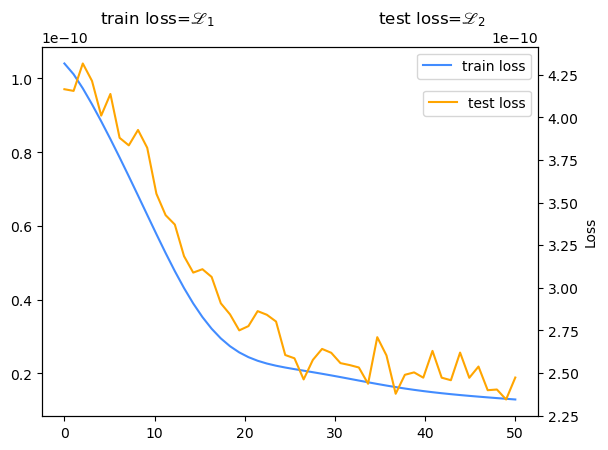

In [54]:
fig, ax_train = plt.subplots()
ax_test = ax_train.twinx()
iteration = np.linspace(0,len(train_loss), len(train_loss))
ax_train.plot(iteration, np.array(train_loss[0:100]), color=(0.26,0.55,1), label="train loss")
ax_train.legend(loc=0, bbox_to_anchor=(1, 1))
ax_test.plot(iteration, np.array(test_loss[0:100]), color="orange", label="test loss")
ax_test.legend(loc=0, bbox_to_anchor=(1, 0.9))
plt.title("           train loss=$\mathscr{L}_1$                               test loss=$\mathscr{L}_2$", loc="left")
plt.xlabel("iteration times")

In [ ]:
im = plt.imshow(abs(roughness_table_list[0]))
plt.colorbar(im)
print(tf.linalg.trace(R_hf @ tf.linalg.inv(R_y)) / SNR)
print(tf.linalg.trace(R_hf) / noise)
print(R_hf[10,10]/noise)
# RSS/noise=1时ε*和ε相差最大，若估计的R_hf特征值偏差比Δλ/λ:=β, 则ε-ε*最大=β^2/4